Trabajo fin de máster:  
#### SISTEMA DE PREDIAGNÓSTICO DE NEUMONÍA MEDIANTE INTELIGENCIA ARTIFICIAL
Autor: **José María de Cuenca**

Cuaderno: **3 - Segmentador para crear nuevo dataset a partir de datos originales**


In [1]:
# Importación de librerías y carga de funciones

import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from skimage import morphology, io, color, exposure, img_as_float, transform
from matplotlib import pyplot as plt

import os
from PIL import Image
import time
import cv2
from skimage.transform import resize


Using TensorFlow backend.


**Segmentador pulmonar**  

Este cuaderno auxiliar utiliza TRANSFERENCIA DE APRENDIZAJE desde una RN preexistente en la red, especializada
en el reconocimiento de lóbulos pulmonares: https://github.com/imlab-uiip/lung-segmentation-2d/blob/master/Demo/demo.py

El código incluido a continuación está inspirado en la demo del repositorio indicado, pero se ha modificado para reducir las imágenes del dataset original del proyecto fin de máster a los pulmones, enmascarando el resto de la imagen, en vez de para identificar los contornos de los lóbulos.  

Comienza definiendo las funciones necesarias para la segmentación

In [2]:
# Funcion para cargar y pre procesar los datos. Usa formato im_shape de 256x256, necesario para RN
# Si se cargan las imagenes con 256x256 para segmentar
def loadDataGeneral(df, path, im_shape):
    X = [] # matriz para las imagenes
    for i, item in df.iterrows(): # bucle de carga
        img = img_as_float(io.imread(item[0]))
            
        img = transform.resize(img, im_shape)
        img = exposure.equalize_hist(img)
        img = np.expand_dims(img, -1) # expande la forma de la matriz
        
        X.append(img)
        
    X = np.array(X)

    # Normalizacion de las imagenes de carga (no de las mascaras)
    X -= X.mean()
    X /= X.std()

    return X # Devuelve array de imagenes a procesar

In [3]:
# Funcion para componer una imagen coloreando cada pulmon en la imagen con la mascara predicha

def mascara(img, mask):
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    
    color_mask[mask == 1] = [0, 0, 1] # fondo de color azul
    
    img_color = np.dstack((img, img, img))

    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1]

    img_mascara = color.hsv2rgb(img_hsv)
    
    return img_mascara # Retorna una imagen con la mascara

**Carga de datos:**  

Para facilitar el manejo de los datos parto del dataframe utilizado en los cuadernos inciales.

In [4]:
### ACCESO Y EXPLORACION DE ARCHIVOS DE DATOS

# Uso el sistema para obtener la Lista con todos los ficheros de la ruta
path = './data/chest_xray' # Variable para la ruta al directorio
lstDir = os.walk(path)   #os.walk()Lista directorios y ficheros


# Creo lista para extraer los datos de la anterior del sistema
# Lista vacia para rellenar con datos de los ficheros
lstFiles = []

for root, dirs, files in lstDir:
    for fichero in files:
        # Separo nombre del fichero de la extension
        (nombreFichero, extension) = os.path.splitext(fichero)
        
        # Controlo que solo se procesen los ficheros jpeg (evitando los .DS_Store u otros)
        if extension == ".jpeg":
            # Compongo la ruta completa, convirtiendo a tipo Unix para independizar de SO. Ojo escape 
            ruta = root.replace("\\", "/")+"/"+nombreFichero+extension
            # Uso la ruta completa como identificador de la imagen
            lstFiles.append(ruta)
            
            # Extraigo el subconjunto de partida
            if root.find("train")>0:
                lstFiles.append("TRAIN")
            else:
                if root.find("test")>0:
                    lstFiles.append("TEST")
                else:
                    lstFiles.append("VAL")
        
            # Extraigo el diagnostico
            if root.find("NORMAL")>0:
                lstFiles.append("NORMAL")
                lstFiles.append("0")
            else:
                lstFiles.append("PNEUMONIA")
                lstFiles.append("1")
        
            # Extraigo el tipo de infeccion
            if root.find("PNEUMONIA")>0:
                if nombreFichero.find("bacteria")>0:
                    lstFiles.append("BACTERIA")
                    lstFiles.append("1")
                else:
                    lstFiles.append("VIRUS")
                    lstFiles.append("2")
            else:
                lstFiles.append("NONE")
                lstFiles.append("0")
                
            # Cargo la imagen para sacar caracteristicas internas
            imagen = Image.open(ruta)
            lstFiles.append(imagen.mode)
            lstFiles.append(imagen.size[0]) # anchura
            lstFiles.append(imagen.size[1]) # altura
            lstFiles.append(round(imagen.size[0]*imagen.size[1]/1000000, 2)) # resolucion Megapixeles
            lstFiles.append(round(imagen.size[0]/imagen.size[1], 4)) # relacion de aspecto



# Para poder crear tabla necestio hacer reshape en la lista. Es necesario pasar por array numpy.          
# Convierto la lista en array numpy
npdf_files = np.array(lstFiles)
# Lo llevo al formato de columnas ordenadas
npdf_files = npdf_files.reshape([-1,11])

# Compruebo que es correcto
print(npdf_files.shape)

# Creo un dataframe de pandas
df_file = pd.DataFrame(npdf_files, columns=['fichero', 'conjunto', 'diagnostico','diag_ct','patogeno', 'patog_ct','color','x_res', 'y_res', 'res_Mpx', 'rel_asp'])

# Lo grabo como csv
df_file.to_csv (path+'/df_file.csv', index = None, header=True)

df_file.head(10)

(5856, 11)


,fichero,conjunto,diagnostico,diag_ct,patogeno,patog_ct,color,x_res,y_res,res_Mpx,rel_asp
0,./data/chest_xray/test/NORMAL/IM-0001-0001.jpeg,TEST,NORMAL,0,NONE,0,L,1857,1317,2.45,1.41
1,./data/chest_xray/test/NORMAL/IM-0003-0001.jpeg,TEST,NORMAL,0,NONE,0,L,2111,1509,3.19,1.3989
2,./data/chest_xray/test/NORMAL/IM-0005-0001.jpeg,TEST,NORMAL,0,NONE,0,L,2031,1837,3.73,1.1056
3,./data/chest_xray/test/NORMAL/IM-0006-0001.jpeg,TEST,NORMAL,0,NONE,0,L,1663,1326,2.21,1.2541
4,./data/chest_xray/test/NORMAL/IM-0007-0001.jpeg,TEST,NORMAL,0,NONE,0,L,2053,1818,3.73,1.1293
5,./data/chest_xray/test/NORMAL/IM-0009-0001.jpeg,TEST,NORMAL,0,NONE,0,L,1852,1443,2.67,1.2834
6,./data/chest_xray/test/NORMAL/IM-0010-0001.jpeg,TEST,NORMAL,0,NONE,0,L,1873,1478,2.77,1.2673
7,./data/chest_xray/test/NORMAL/IM-0011-0001-000...,TEST,NORMAL,0,NONE,0,L,2144,1916,4.11,1.119
8,./data/chest_xray/test/NORMAL/IM-0011-0001-000...,TEST,NORMAL,0,NONE,0,L,2214,1945,4.31,1.1383
9,./data/chest_xray/test/NORMAL/IM-0011-0001.jpeg,TEST,NORMAL,0,NONE,0,L,1863,1785,3.33,1.0437


**Estructura de ficheros**

Divido el dataframe en varias partes para facilitar el procesado de segmentación posterior, ya que veo que al trabajar en conjuntos de menor tamaño resulta más eficiente. Utilizo tablas auxiliares en CSV para ello.  

También creo una estructura paralela en disco, para poder almacenar el nuevo dataset de imágenes segmentadas.

In [30]:
# Genero ficheros CSVs separados para carpeta de datos que replicara el segmentador
# Divido los conjuntos para procesar por partes

## CONJUNTO DE VALIDACION

# Filtro y grabo
VAL_NOR_file = (df_file[(df_file['conjunto']=='VAL') & (df_file['diagnostico']=='NORMAL')]['fichero'].iloc[:])
VAL_NOR_file.to_csv ('./data/chest_xray/VAL_NOR_file.csv', index = None, header=True)

# Filtro y grabo
VAL_PNE_file = (df_file[(df_file['conjunto']=='VAL') & (df_file['diagnostico']=='PNEUMONIA')]['fichero'].iloc[:])
VAL_PNE_file.to_csv ('./data/chest_xray/VAL_PNE_file.csv', index = None, header=True)


## CONJUNTO DE PRUEBA

# Filtro y grabo
TEST_NOR_file = (df_file[(df_file['conjunto']=='TEST') & (df_file['diagnostico']=='NORMAL')]['fichero'].iloc[:])
TEST_NOR_file.to_csv ('./data/chest_xray/TEST_NOR_file.csv', index = None, header=True)

# Filtro y grabo
TEST_PNE_file = (df_file[(df_file['conjunto']=='TEST') & (df_file['diagnostico']=='PNEUMONIA')]['fichero'].iloc[:])
TEST_PNE_file.to_csv ('./data/chest_xray/TEST_PNE_file.csv', index = None, header=True)


## CONJUNTO DE ENTRENAMIENTO

# Filtro y grabo
TRAIN_NOR_file = (df_file[(df_file['conjunto']=='TRAIN') & (df_file['diagnostico']=='NORMAL')]['fichero'].iloc[:])
TRAIN_NOR_file.to_csv ('./data/chest_xray/TRAIN_NOR_file.csv', index = None, header=True)

# Filtro y grabo
# Añado condicion especial de imagenes en escala de grises porque esta red no permite RGB
TRAIN_PNE_file = (df_file[(df_file['conjunto']=='TRAIN') & (df_file['diagnostico']=='PNEUMONIA') & (df_file['color']=='L')]['fichero'].iloc[:])
TRAIN_PNE_file.to_csv ('./data/chest_xray/TRAIN_PNE_file.csv', index = None, header=True)


In [8]:
# Creo estructura de carpetas si no existen ya

try:
    os.stat('./data/chest_xray_seg')
except:
    os.mkdir('./data/chest_xray_seg')

    
try:
    os.stat('./data/chest_xray_seg/test')
except:
    os.mkdir('./data/chest_xray_seg/test')

    
try:
    os.stat('./data/chest_xray_seg/test/NORMAL')
except:
    os.mkdir('./data/chest_xray_seg/test/NORMAL')

try:
    os.stat('./data/chest_xray_seg/test/PNEUMONIA')
except:
    os.mkdir('./data/chest_xray_seg/test/PNEUMONIA')
    
try:
    os.stat('./data/chest_xray_seg/train')
except:
    os.mkdir('./data/chest_xray_seg/train')

    
try:
    os.stat('./data/chest_xray_seg/train/NORMAL')
except:
    os.mkdir('./data/chest_xray_seg/train/NORMAL')
    
    
try:
    os.stat('./data/chest_xray_seg/train/PNEUMONIA')
except:
    os.mkdir('./data/chest_xray_seg/train/PNEUMONIA')
    
    
try:
    os.stat('./data/chest_xray_seg/val')
except:
    os.mkdir('./data/chest_xray_seg/val')

    
try:
    os.stat('./data/chest_xray_seg/val/NORMAL')
except:
    os.mkdir('./data/chest_xray_seg/val/NORMAL')
    
    
try:
    os.stat('./data/chest_xray_seg/val/PNEUMONIA')
except:
    os.mkdir('./data/chest_xray_seg/val/PNEUMONIA')

**Generación de imágenes segmentadas**

Ejecuto para cada conjunto de imágenes del dataset original la rutina de segmentación, aplicando la transformación 
de la red neuronal transferida.  

Para ello cargo las imágenes en su formato de entrada (256x256), aunque posteriormente en los modelos de análisis de este trabajo deba volver a cambiarlo para mantener la homogeneidad entre todos los cuadernos de pruebas.  

Las imágenes segmentadas se van guardando en la carpeta correspondiente de la nueva ruta.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


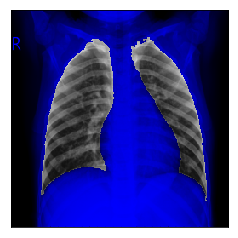

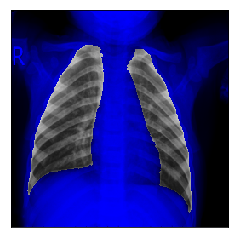

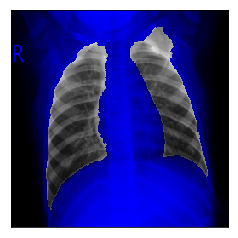

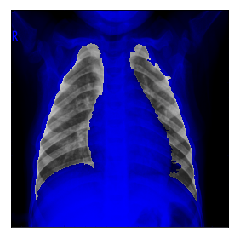

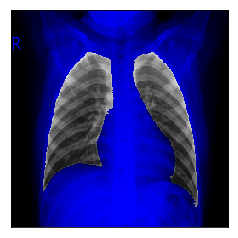

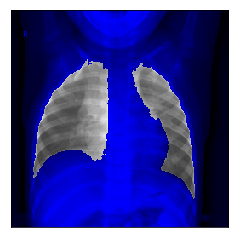

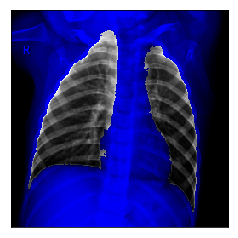

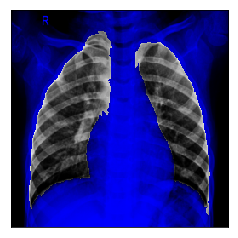

In [9]:
### GENERADOR IMAGENES SEGMENTADAS PARA CADA ARCHIVO

# Defino ubicacion para el archivo de rutas a procesar, a partir del raiz del usuario
csv_path = './data/chest_xray/VAL_NOR_file.csv'
path = '.'

df = pd.read_csv(csv_path) # dataframe con las rutas del fichero

    
## Define el formato de carga de las imagenes usando la funcion anterior
im_shape = (256, 256) # Respeto el original de la RN de segmentación
X = loadDataGeneral(df, path, im_shape) # arrays de numpy cargados a partir de las rutas con el formato 256x256
n_test = X.shape[0] # Toma el numero de datos a tratar
inp_shape = X[0].shape # Averigua las dimensiones de las imagenes segun la primera (256,256,1)


### MODELO DE SEGMENTACION

n_test = X.shape[0] # Toma el numero de datos a tratar en las carpetas de la ruta

# Load model - Transferencia de aprendizaje
model_name = './checkpoints/Segmentation_model.hdf5' # modelo entrenado
UNet = load_model(model_name) # funcion de keras para cargar modelo


# Defino generador para extraer secuencia de pixeles de las imagenes
test_gen = ImageDataGenerator(rescale=1.) # Indica reescalado 1.


i = 0

# Hace predicciones de mascara a partir del flujo de pixeles alimentado por el generador para cada imagen
for xx in test_gen.flow(X, batch_size=1):
    img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1)) # recompone una imagen a partir de sus plixeles, reescalando su intensidad
    pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2]) # Usa el modelo cargado para predecir la mascara de la imagen
    
    # Crea una mascara binaria a partir de la predicccion
    pr = pred < 0.5 # Si la prediccion es mayor de 0.5 almacena True

    # Elimino las regiones pequeñas en las imagenes
    pr = morphology.remove_small_objects(pr, 0.02 * np.prod(im_shape))
    pr = morphology.remove_small_holes(pr, 0.02 * np.prod(im_shape))

    
    # Compongo imagenes enmascaradas
    if i < n_test:
            # plt.imshow(pred) # Dibuja la mascara predicha
            # plt.imshow(mascara(img, pr, pr)) # Dibuja la imagen aplicando la mascara predicha
            plt.imshow(mascara(img, pr)) # Dibuja la imagen aplicando la mascara predicha
            
            # Elimino marcas de ejes
            plt.xticks([])
            plt.yticks([])
            
            # Genero ruta para guardar la nueva imagen
            ruta = str(df.iloc[i,0])
            img_seg = ruta.replace('chest_xray', 'chest_xray_seg')
            
            # Guardo la nueva imagen
            plt.savefig(img_seg) # Graba la figura compuesta de las dos
            
            print(img_seg)
    i += 1
    
    if i == n_test:
        break
    
    # plt.show() # No represento cada una, con la ultima es suficiente


./data/chest_xray_seg/val/PNEUMONIA/person1946_bacteria_4874.jpeg
./data/chest_xray_seg/val/PNEUMONIA/person1946_bacteria_4875.jpeg
./data/chest_xray_seg/val/PNEUMONIA/person1947_bacteria_4876.jpeg
./data/chest_xray_seg/val/PNEUMONIA/person1949_bacteria_4880.jpeg
./data/chest_xray_seg/val/PNEUMONIA/person1950_bacteria_4881.jpeg
./data/chest_xray_seg/val/PNEUMONIA/person1951_bacteria_4882.jpeg
./data/chest_xray_seg/val/PNEUMONIA/person1952_bacteria_4883.jpeg
./data/chest_xray_seg/val/PNEUMONIA/person1954_bacteria_4886.jpeg


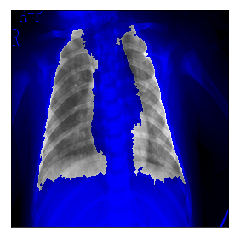

In [11]:
### GENERADOR IMAGENES SEGMENTADAS PARA CADA ARCHIVO

# Defino ubicacion para el archivo de rutas a procesar, a partir del raiz del usuario
csv_path = './data/chest_xray/VAL_PNE_file.csv'
path = '.'

df = pd.read_csv(csv_path) # dataframe con las rutas del fichero

    
## Define el formato de carga de las imagenes usando la funcion anterior
im_shape = (256, 256) # Respeto el original de la RN de segmentación
X = loadDataGeneral(df, path, im_shape) # arrays de numpy cargados a partir de las rutas con el formato 256x256
n_test = X.shape[0] # Toma el numero de datos a tratar
inp_shape = X[0].shape # Averigua las dimensiones de las imagenes según la primera (256,256,1)


### MODELO DE SEGMENTACION

n_test = X.shape[0] # Toma el numero de datos a tratar en las carpetas de la ruta

# Load model - Transferencia de aprendizaje
model_name = './checkpoints/Segmentation_model.hdf5' # modelo entrenado
UNet = load_model(model_name) # funcion de keras para cargar modelo


# Defino generador para extraer secuencia de pixeles de las imagenes
test_gen = ImageDataGenerator(rescale=1.) # Indica reescalado 1. 


i = 0

# Hace predicciones de mascara a partir del flujo de pixeles alimentado por el generador para cada imagen
for xx in test_gen.flow(X, batch_size=1):
    img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1)) # recompone una imagen a partir de sus plixeles, reescalando su intensidad
    pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2]) # Usa el modelo cargado para predecir la mascara de la imagen
    
    # Crea una mascara binaria a partir de la predicccion
    pr = pred < 0.5 # Si la prediccion es mayor de 0.5 almacena True

    # Elimino las regiones pequeñas en las imagenes
    pr = morphology.remove_small_objects(pr, 0.02 * np.prod(im_shape))
    pr = morphology.remove_small_holes(pr, 0.02 * np.prod(im_shape))

    
    # Compongo imagenes enmascaradas
    if i < n_test:

            plt.imshow(mascara(img, pr)) # Dibuja la imagen aplicando la mascara predicha
            
            # Elimino marcas de ejes
            plt.xticks([])
            plt.yticks([])
            
            # Genero ruta para guardar la nueva imagen
            ruta = str(df.iloc[i,0])
            img_seg = ruta.replace('chest_xray', 'chest_xray_seg')
            
            # Guardo la nueva imagen
            plt.savefig(img_seg) # Graba la figura compuesta de las dos
            
            print(img_seg)
    i += 1
    
    if i == n_test:
        break
    
    # plt.show() # No represento cada una, con la ultima es suficiente

./data/chest_xray_seg/test/PNEUMONIA/person100_bacteria_475.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person100_bacteria_477.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person100_bacteria_478.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person100_bacteria_479.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person100_bacteria_480.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person100_bacteria_481.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person100_bacteria_482.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person101_bacteria_483.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person101_bacteria_484.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person101_bacteria_485.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person101_bacteria_486.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person102_bacteria_487.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person103_bacteria_488.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person103_bacteria_489.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person103_bacteria_490.jpeg
./data/chest_xray_seg/tes

./data/chest_xray_seg/test/PNEUMONIA/person141_bacteria_678.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person141_bacteria_681.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person142_bacteria_682.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person142_bacteria_683.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person142_bacteria_684.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person143_bacteria_687.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person143_bacteria_688.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person143_bacteria_689.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person144_bacteria_690.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person145_bacteria_696.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person146_bacteria_700.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person146_bacteria_703.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person146_bacteria_704.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person147_bacteria_705.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person147_bacteria_706.jpeg
./data/chest_xray_seg/tes

./data/chest_xray_seg/test/PNEUMONIA/person1_virus_13.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person1_virus_6.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person1_virus_7.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person1_virus_8.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person1_virus_9.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person20_virus_51.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person21_virus_52.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person21_virus_53.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person22_virus_54.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person22_virus_55.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person23_virus_56.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person24_virus_58.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person25_virus_59.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person26_virus_60.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person28_virus_62.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person28_virus_63.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person29_vir

./data/chest_xray_seg/test/PNEUMONIA/person99_bacteria_473.jpeg
./data/chest_xray_seg/test/PNEUMONIA/person99_bacteria_474.jpeg


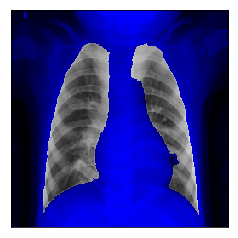

In [12]:
### GENERADOR IMAGENES SEGMENTADAS PARA CADA ARCHIVO

# Defino ubicacion para el archivo de rutas a procesar, a partir del raiz del usuario
csv_path = './data/chest_xray/TEST_PNE_file.csv'
path = '.'

df = pd.read_csv(csv_path) # dataframe con las rutas del fichero

    
## Define el formato de carga de las imagenes usando la funcion anterior
im_shape = (256, 256) # Respeto el original de la RN de segmentación
X = loadDataGeneral(df, path, im_shape) # arrays de numpy cargados a partir de las rutas con el formato 256x256
n_test = X.shape[0] # Toma el numero de datos a tratar
inp_shape = X[0].shape # Averigua las dimensiones de las imagenes según la primera (256,256,1)


### MODELO DE SEGMENTACION

n_test = X.shape[0] # Toma el numero de datos a tratar en las carpetas de la ruta

# Load model - Transferencia de aprendizaje
model_name = './checkpoints/Segmentation_model.hdf5' # modelo entrenado
UNet = load_model(model_name) # funcion de keras para cargar modelo


# Defino generador para extraer secuencia de pixeles de las imagenes
test_gen = ImageDataGenerator(rescale=1.) # Indica reescalado 1. 


i = 0

# Hace predicciones de mascara a partir del flujo de pixeles alimentado por el generador para cada imagen
for xx in test_gen.flow(X, batch_size=1):
    img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1)) # recompone una imagen a partir de sus plixeles, reescalando su intensidad
    pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2]) # Usa el modelo cargado para predecir la mascara de la imagen
    
    # Crea una mascara binaria a partir de la predicccion
    pr = pred < 0.5 # Si la prediccion es mayor de 0.5 almacena True

    # Elimino las regiones pequeñas en las imagenes
    pr = morphology.remove_small_objects(pr, 0.02 * np.prod(im_shape))
    pr = morphology.remove_small_holes(pr, 0.02 * np.prod(im_shape))

    
    # Compongo imagenes enmascaradas
    if i < n_test:

            plt.imshow(mascara(img, pr)) # Dibuja la imagen aplicando la mascara predicha
            
            # Elimino marcas de ejes
            plt.xticks([])
            plt.yticks([])
            
            # Genero ruta para guardar la nueva imagen
            ruta = str(df.iloc[i,0])
            img_seg = ruta.replace('chest_xray', 'chest_xray_seg')
            
            # Guardo la nueva imagen
            plt.savefig(img_seg) # Graba la figura compuesta de las dos
            
            print(img_seg)
    i += 1
    
    if i == n_test:
        break
    
    # plt.show() # No represento cada una, con la ultima es suficiente

Procesando  234 archivos
./data/chest_xray_seg/test/NORMAL/IM-0001-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0003-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0005-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0006-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0007-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0009-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0010-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0011-0001-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0011-0001-0002.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0011-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0013-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0015-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0016-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0017-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0019-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0021-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0022-0001.jpeg
./data/chest_xray_seg/test/NORMAL/IM-0023-0001.jpeg
./data/chest_xray_seg/test/NO

./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0259-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0267-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0271-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0272-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0273-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0274-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0275-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0276-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0277-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0278-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0279-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0280-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0281-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0282-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0283-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL2-IM-0285-0001.jpeg
./data/chest_xray_seg/test/NORMAL/NORMAL

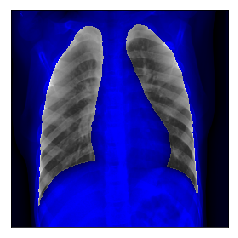

In [13]:
### GENERADOR IMAGENES SEGMENTADAS PARA CADA ARCHIVO

# Defino ubicacion para el archivo de rutas a procesar, a partir del raiz del usuario
csv_path = './data/chest_xray/TEST_NOR_file.csv'
path = '.'

df = pd.read_csv(csv_path) # dataframe con las rutas del fichero

    
## Define el formato de carga de las imagenes usando la funcion anterior
im_shape = (256, 256) # Respeto el original de la RN de segmentación
X = loadDataGeneral(df, path, im_shape) # arrays de numpy cargados a partir de las rutas con el formato 256x256
n_test = X.shape[0] # Toma el numero de datos a tratar
inp_shape = X[0].shape # Averigua las dimensiones de las imagenes según la primera (256,256,1)


### MODELO DE SEGMENTACION

n_test = X.shape[0] # Toma el numero de datos a tratar en las carpetas de la ruta

print('Procesando ', n_test, 'archivos')

# Load model - Transferencia de aprendizaje
model_name = './checkpoints/Segmentation_model.hdf5' # modelo entrenado
UNet = load_model(model_name) # funcion de keras para cargar modelo


# Defino generador para extraer secuencia de pixeles de las imagenes
test_gen = ImageDataGenerator(rescale=1.) # Indica reescalado 1. 


i = 0

# Hace predicciones de mascara a partir del flujo de pixeles alimentado por el generador para cada imagen
for xx in test_gen.flow(X, batch_size=1):
    img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1)) # recompone una imagen a partir de sus plixeles, reescalando su intensidad
    pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2]) # Usa el modelo cargado para predecir la mascara de la imagen
    
    # Crea una mascara binaria a partir de la predicccion
    pr = pred < 0.5 # Si la prediccion es mayor de 0.5 almacena True

    # Elimino las regiones pequeñas en las imagenes
    pr = morphology.remove_small_objects(pr, 0.02 * np.prod(im_shape))
    pr = morphology.remove_small_holes(pr, 0.02 * np.prod(im_shape))

    
    # Compongo imagenes enmascaradas
    if i < n_test:

            plt.imshow(mascara(img, pr)) # Dibuja la imagen aplicando la mascara predicha
            
            # Elimino marcas de ejes
            plt.xticks([])
            plt.yticks([])
            
            # Genero ruta para guardar la nueva imagen
            ruta = str(df.iloc[i,0])
            img_seg = ruta.replace('chest_xray', 'chest_xray_seg')
            
            # Guardo la nueva imagen
            plt.savefig(img_seg) # Graba la figura compuesta de las dos
            
            print(img_seg)
    i += 1
    
    if i == n_test:
        break
    
    # plt.show() # No represento cada una, con la ultima es suficiente

Procesando  1341 archivos
./data/chest_xray_seg/train/NORMAL/IM-0115-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0117-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0119-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0122-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0125-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0127-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0128-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0129-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0131-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0133-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0135-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0137-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0140-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0141-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0143-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0145-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0147-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0149-0001.jpeg
./data/chest_xray_se

./data/chest_xray_seg/train/NORMAL/IM-0339-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0340-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0341-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0343-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0345-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0346-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0347-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0348-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0349-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0350-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0351-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0353-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0354-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0355-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0356-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0357-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0358-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0359-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0361-000

./data/chest_xray_seg/train/NORMAL/IM-0502-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0503-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0504-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0505-0001-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0505-0001-0002.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0505-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0506-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0507-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0508-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0509-0001-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0509-0001-0002.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0509-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0510-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0511-0001-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0511-0001-0002.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0511-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0512-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0513-0001.jpeg
./data/chest_xra

./data/chest_xray_seg/train/NORMAL/IM-0626-0001-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0626-0001-0002.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0627-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0628-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0629-0001-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0629-0001-0002.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0629-0001-0003.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0629-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0630-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0631-0001-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0631-0001-0002.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0631-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0632-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0633-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0634-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0635-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0636-0001.jpeg
./data/chest_xray_seg/train/NORMAL/IM-0637-0001.jpeg
./data/ches

./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0395-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0396-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0397-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0399-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0401-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0402-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0403-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0404-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0406-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0407-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0408-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0409-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0410-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0412-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0413-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0414-0001.jpeg
./data/chest_xray_seg/tr

./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0575-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0576-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0577-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0578-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0579-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0580-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0582-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0583-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0585-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0587-0001-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0587-0001-0002.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0587-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0588-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0589-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0592-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0594-0001.jpeg
./data/chest_x

./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0818-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0819-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0820-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0821-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0822-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0824-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0825-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0826-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0827-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0828-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0829-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0830-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0831-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0832-0001-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0832-0001-0002.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0832-0001.jpeg
./data/chest_x

./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0974-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0975-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0976-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0977-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0978-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0979-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0980-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0981-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0983-0001-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0983-0001-0002.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0983-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0986-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0987-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0988-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0989-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-0992-0001.jpeg
./data/chest_x

./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1144-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1145-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1147-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1148-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1149-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1150-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1151-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1152-0001-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1152-0001-0002.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1152-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1153-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1154-0001-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1154-0001-0002.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1154-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1155-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1156-0001.jpeg
./da

./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1302-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1303-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1304-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1305-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1306-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1307-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1308-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1310-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1311-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1314-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1315-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1316-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1318-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1319-0001.jpeg
./data/chest_xray_seg/train/NORMAL/NORMAL2-IM-1320-0001.jpeg
./data/chest_xray_seg/tr

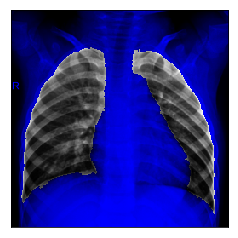

In [14]:
### GENERADOR IMAGENES SEGMENTADAS PARA CADA ARCHIVO

# Defino ubicacion para el archivo de rutas a procesar, a partir del raiz del usuario
csv_path = './data/chest_xray/TRAIN_NOR_file.csv'
path = '.'

df = pd.read_csv(csv_path) # dataframe con las rutas del fichero

    
## Define el formato de carga de las imagenes usando la funcion anterior
im_shape = (256, 256) # Respeto el original de la RN de segmentación
X = loadDataGeneral(df, path, im_shape) # arrays de numpy cargados a partir de las rutas con el formato 256x256
n_test = X.shape[0] # Toma el numero de datos a tratar
inp_shape = X[0].shape # Averigua las dimensiones de las imagenes según la primera (256,256,1)


### MODELO DE SEGMENTACION

n_test = X.shape[0] # Toma el numero de datos a tratar en las carpetas de la ruta

print('Procesando ', n_test, 'archivos')

# Load model - Transferencia de aprendizaje
model_name = './checkpoints/Segmentation_model.hdf5' # modelo entrenado
UNet = load_model(model_name) # funcion de keras para cargar modelo


# Defino generador para extraer secuencia de pixeles de las imagenes
test_gen = ImageDataGenerator(rescale=1.) # Indica reescalado 1. 


i = 0

# Hace predicciones de mascara a partir del flujo de pixeles alimentado por el generador para cada imagen
for xx in test_gen.flow(X, batch_size=1):
    img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1)) # recompone una imagen a partir de sus plixeles, reescalando su intensidad
    pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2]) # Usa el modelo cargado para predecir la mascara de la imagen
    
    # Crea una mascara binaria a partir de la predicccion
    pr = pred < 0.5 # Si la prediccion es mayor de 0.5 almacena True

    # Elimino las regiones pequeñas en las imagenes
    pr = morphology.remove_small_objects(pr, 0.02 * np.prod(im_shape))
    pr = morphology.remove_small_holes(pr, 0.02 * np.prod(im_shape))

    
    # Compongo imagenes enmascaradas
    if i < n_test:

            plt.imshow(mascara(img, pr)) # Dibuja la imagen aplicando la mascara predicha
            
            # Elimino marcas de ejes
            plt.xticks([])
            plt.yticks([])
            
            # Genero ruta para guardar la nueva imagen
            ruta = str(df.iloc[i,0])
            img_seg = ruta.replace('chest_xray', 'chest_xray_seg')
            
            # Guardo la nueva imagen
            plt.savefig(img_seg) # Graba la figura compuesta de las dos
            
            print(img_seg)
    i += 1
    
    if i == n_test:
        break
    
    # plt.show() # No represento cada una, con la ultima es suficiente

./data/chest_xray_seg/train/PNEUMONIA/person881_bacteria_2805.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person881_virus_1531.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person882_bacteria_2806.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person883_bacteria_2807.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person883_virus_1533.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person884_bacteria_2808.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person884_virus_1534.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person885_bacteria_2809.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person886_bacteria_2810.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person886_virus_1536.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person887_bacteria_2811.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person888_virus_1538.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person889_bacteria_2813.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person88_virus_161.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person88_virus_163.jpeg
./data/chest_xray_se

./data/chest_xray_seg/train/PNEUMONIA/person962_bacteria_2887.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person962_virus_1635.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person963_bacteria_2888.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person964_virus_1637.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person965_bacteria_2890.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person966_virus_1639.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person967_bacteria_2892.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person967_virus_1640.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person968_bacteria_2893.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person968_virus_1642.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person969_bacteria_2894.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person969_virus_1643.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person96_virus_178.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person96_virus_179.jpeg
./data/chest_xray_seg/train/PNEUMONIA/person970_bacteria_2895.jpeg
./data/chest_xray_seg/t

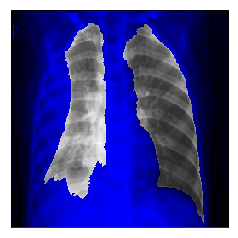

In [11]:
### GENERADOR IMAGENES SEGMENTADAS PARA CADA ARCHIVO

# Defino ubicacion para el archivo de rutas a procesar, a partir del raiz del usuario
csv_path = './data/chest_xray/TRAIN_PNE_file.csv'
path = '.'

df = pd.read_csv(csv_path) # dataframe con las rutas del fichero

    
## Define el formato de carga de las imagenes usando la funcion anterior
im_shape = (256, 256) # Respeto el original de la RN de segmentación
X = loadDataGeneral(df, path, im_shape) # arrays de numpy cargados a partir de las rutas con el formato 256x256
n_test = X.shape[0] # Toma el numero de datos a tratar
inp_shape = X[0].shape # Averigua las dimensiones de las imagenes según la primera (256,256,1)


### MODELO DE SEGMENTACION

n_test = X.shape[0] # Toma el numero de datos a tratar en las carpetas de la ruta

# Load model - Transferencia de aprendizaje
model_name = './checkpoints/Segmentation_model.hdf5' # modelo entrenado
UNet = load_model(model_name) # funcion de keras para cargar modelo


# Defino generador para extraer secuencia de pixeles de las imagenes
test_gen = ImageDataGenerator(rescale=1.) # Indica reescalado 1. 


i = 0

# Hace predicciones de mascara a partir del flujo de pixeles alimentado por el generador para cada imagen
for xx in test_gen.flow(X, batch_size=1):
    img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1)) # recompone una imagen a partir de sus plixeles, reescalando su intensidad
    pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2]) # Usa el modelo cargado para predecir la mascara de la imagen
    
    # Crea una mascara binaria a partir de la predicccion
    pr = pred < 0.5 # Si la prediccion es mayor de 0.5 almacena True

    # Elimino las regiones pequeñas en las imagenes
    pr = morphology.remove_small_objects(pr, 0.02 * np.prod(im_shape))
    pr = morphology.remove_small_holes(pr, 0.02 * np.prod(im_shape))

    
    # Compongo imagenes enmascaradas
    if i < n_test:

            plt.imshow(mascara(img, pr)) # Dibuja la imagen aplicando la mascara predicha
            
            # Elimino marcas de ejes
            plt.xticks([])
            plt.yticks([])
            
            # Genero ruta para guardar la nueva imagen
            ruta = str(df.iloc[i,0])
            img_seg = ruta.replace('chest_xray', 'chest_xray_seg')
            
            # Guardo la nueva imagen
            plt.savefig(img_seg) # Graba la figura compuesta de las dos
            
            print(img_seg)
    i += 1
    
    if i == n_test:
        break
    
    # plt.show() # No represento cada una, con la ultima es suficiente

In [ ]:
# Ver tambien segmentacion basada en histograma solamente:
# https://claudiovz.github.io/scipy-lecture-notes-ES/advanced/image_processing/index.html#segmentacion
